In [4]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

Some ideas:
- statistical arbitrage
-

Resources:
- https://quantocracy.com/
- https://arxiv.org/ftp/arxiv/papers/1601/1601.00991.pdf


[*********************100%***********************]  1 of 1 completed


                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2022-01-03  1.137385  1.137592  1.128541  1.137346   1.137346       0
2022-01-04  1.130199  1.132300  1.127345  1.130224   1.130224       0
2022-01-05  1.128541  1.134559  1.127764  1.128363   1.128363       0
2022-01-06  1.131222  1.133067  1.128554  1.131350   1.131350       0
2022-01-07  1.129586  1.135976  1.129050  1.129688   1.129688       0


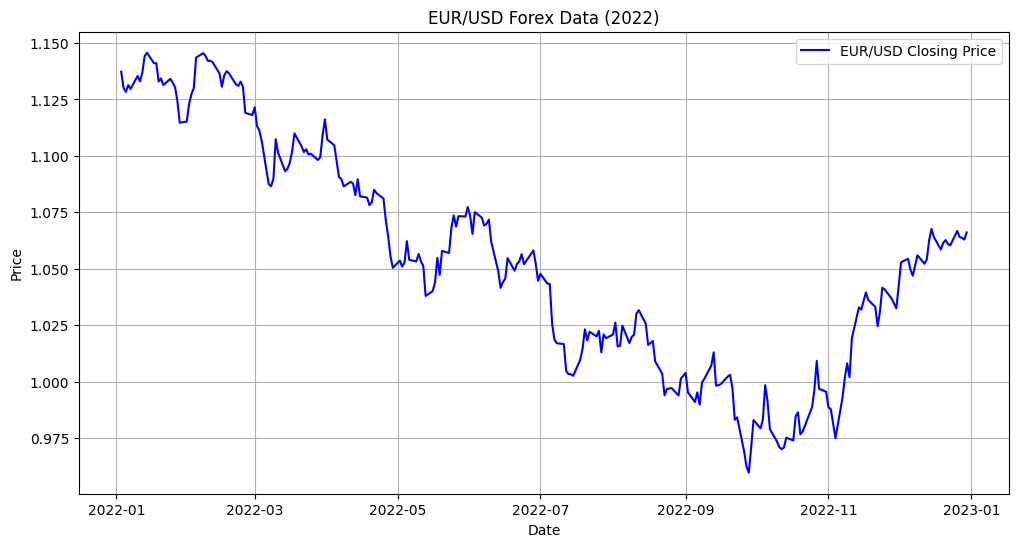

In [5]:
currency_pair = 'EURUSD=X'

# Download historical Forex data
forex_data = yf.download(currency_pair, start='2022-01-01', end='2023-01-01')

# Display the first few rows
print(forex_data.head())

# Plot the closing prices
plt.figure(figsize=(12, 6))
plt.plot(forex_data['Close'], label='EUR/USD Closing Price', color='blue')
plt.title('EUR/USD Forex Data (2022)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

[*********************100%***********************]  2 of 2 completed
c:\Users\kanha\anaconda3\envs\QuantProj\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005012. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\kanha\anaconda3\envs\QuantProj\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000495. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=Fal

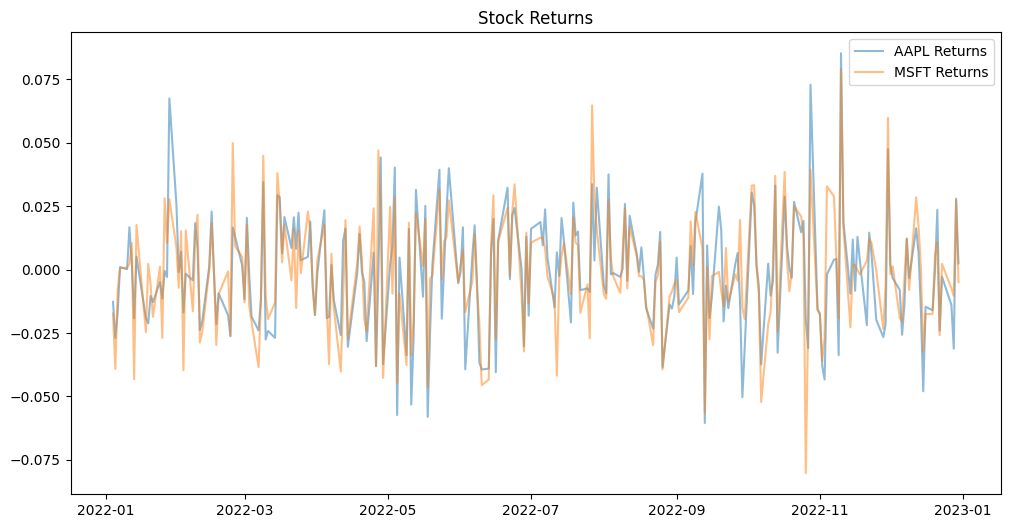

Predicted Volatility AAPL: 0.0004957214777130465
Predicted Volatility MSFT: 0.000511794056164883


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf

# Step 1: Collect Data
symbols = ['AAPL', 'MSFT']
data = yf.download(symbols, start='2022-01-01', end='2023-01-01')['Adj Close']
returns = np.log(data / data.shift(1)).dropna()

# Step 2: Fit Diagonal BEKK GARCH Model for each asset
# Fit GARCH model for each return series
aapl_model = arch_model(returns['AAPL'], vol='Garch', p=1, q=1, dist='normal')
msft_model = arch_model(returns['MSFT'], vol='Garch', p=1, q=1, dist='normal')

aapl_fit = aapl_model.fit(disp='off')
msft_fit = msft_model.fit(disp='off')

# Step 3: Forecast Volatility
aapl_forecast = aapl_fit.forecast(horizon=5)
msft_forecast = msft_fit.forecast(horizon=5)

predicted_volatility_aapl = aapl_forecast.variance.values[-1, 0]  # Get scalar value for AAPL
predicted_volatility_msft = msft_forecast.variance.values[-1, 0]  # Get scalar value for MSFT

# Step 4: Trading Strategy
# Example Strategy: Buy when predicted volatility is low
threshold_aapl = np.percentile(aapl_forecast.variance.values[-1], 25)  # Buy/Sell threshold
threshold_msft = np.percentile(msft_forecast.variance.values[-1], 25)

signals_aapl = (predicted_volatility_aapl < threshold_aapl).astype(int)  # 1 for buy, 0 for hold
signals_msft = (predicted_volatility_msft < threshold_msft).astype(int)

# Step 5: Visualization
plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns['AAPL'], label='AAPL Returns', alpha=0.5)
plt.plot(returns.index, returns['MSFT'], label='MSFT Returns', alpha=0.5)
plt.title('Stock Returns')
plt.legend()
plt.show()

print('Predicted Volatility AAPL:', predicted_volatility_aapl)
print('Predicted Volatility MSFT:', predicted_volatility_msft)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import datetime
import pandas as pd
import statsmodels.tsa.stattools as ts
from scipy.stats import linregress
import warnings 

warnings.filterwarnings("ignore")

def download_data(stock, start, end):
    stock_data = {}
    ticker = yf.download(stock, start,end, progress=False)
    stock_data['price'] = ticker['Adj Close']
    return pd.DataFrame(stock_data)

def filter_non_null_rows(df1, df2):
    # Create a mask for rows that are not null in both DataFrames
    mask = df1.notnull() & df2.notnull() 
    # Filter both DataFrames using the mask
    filtered_df1 = df1[mask.all(axis=1)]
    filtered_df2 = df2[mask.all(axis=1)]
    return filtered_df1, filtered_df2

tick_list = ['EUR=X','GBP=X', 'JPY=X', 'CNY=X', 'HKD=X', 'SGD=X', 'INR=X', 'MXN=X', 'PHP=X', 'IDR=X', 'THB=X', 'MYR=X', 'ZAR=X', 'RUB=X']

if __name__ == '__main__':
    start_date = datetime.datetime(2015,1,1)
    end_date = datetime.datetime(2024,6,1)

    for i in tick_list:
        for j in tick_list:
            if i != j:
                pair1, pair2 = filter_non_null_rows(download_data(i, start_date, end_date), download_data(j, start_date, end_date))
                if np.shape(pair1) == np.shape(pair2):
                    result = linregress(pair1.values[:,0], pair2.values[:,0]) 
                    residuals = pair1 - result.slope * pair2 
                    adf = ts.adfuller(residuals)
                    if adf[1] < 0.01: #Testing for which pairs are critical in 1% significance level
                        print(i, j, adf)

SGD=X HKD=X (np.float64(-4.013372656454384), np.float64(0.0013420843138222552), 0, 2453, {'1%': np.float64(-3.433018632796697), '5%': np.float64(-2.8627189778654643), '10%': np.float64(-2.567397617255774)}, np.float64(-19477.993518011135))


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import datetime
import pandas as pd
import statsmodels.tsa.stattools as ts
from scipy.stats import linregress
import warnings 

warnings.filterwarnings("ignore")

def download_data(stock, start, end):
    stock_data = {}
    ticker = yf.download(stock, start,end, progress=False)
    stock_data['price'] = ticker['Adj Close']
    return pd.DataFrame(stock_data)

def filter_non_null_rows(df1, df2):
    # Create a mask for rows that are not null in both DataFrames
    mask = df1.notnull() & df2.notnull() 
    # Filter both DataFrames using the mask
    filtered_df1 = df1[mask.all(axis=1)]
    filtered_df2 = df2[mask.all(axis=1)]
    return filtered_df1, filtered_df2

tick_list = ['EUR=X','GBP=X', 'JPY=X', 'CNY=X', 'HKD=X', 'SGD=X', 'INR=X', 'MXN=X', 'PHP=X', 'IDR=X', 'THB=X', 'MYR=X', 'ZAR=X', 'RUB=X']

if __name__ == '__main__':
    start_date = datetime.datetime(2015,1,1)
    end_date = datetime.datetime(2024,6,1)

    for i in tick_list:
        pair1 = download_data(i, start_date, end_date).dropna()
        adf = ts.adfuller(pair1)
        if adf[1] < 0.01: #Testing for which pairs are critical in 1% significance level
                print(i, adf)

SGD=X (np.float64(-3.719922166025504), np.float64(0.0038414993660393732), 0, 2453, {'1%': np.float64(-3.433018632796697), '5%': np.float64(-2.8627189778654643), '10%': np.float64(-2.567397617255774)}, np.float64(-19695.514402533903))


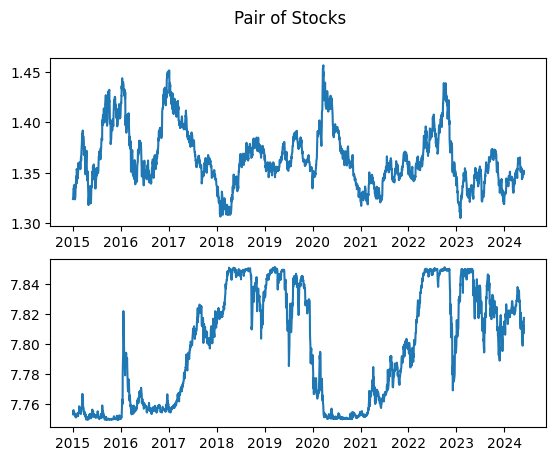

LinregressResult(slope=np.float64(-0.24941494576666143), intercept=np.float64(8.137654341553043), rvalue=np.float64(-0.19291714591889614), pvalue=np.float64(5.2859366127699415e-22), stderr=np.float64(0.025618613053744722), intercept_stderr=np.float64(0.03497607814566398))
(np.float64(-4.013372656454384), np.float64(0.0013420843138222552), 0, 2453, {'1%': np.float64(-3.433018632796697), '5%': np.float64(-2.8627189778654643), '10%': np.float64(-2.567397617255774)}, np.float64(-19477.993518011135))


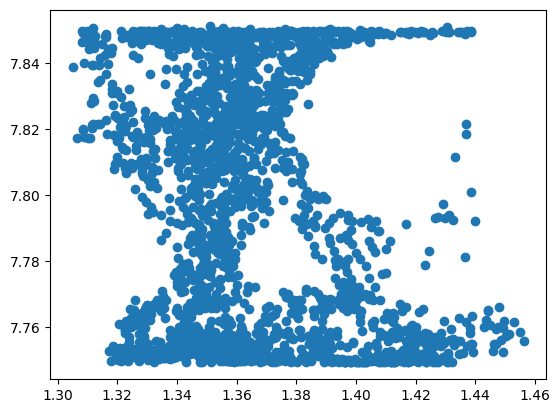

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import datetime
import pandas as pd
import statsmodels.tsa.stattools as ts
from scipy.stats import linregress

def download_data(stock, start, end):
    stock_data = {}
    ticker = yf.download(stock, start,end, progress=False)
    stock_data['price'] = ticker['Adj Close']
    return pd.DataFrame(stock_data)

def plot_pairs(data1, data2):
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle("Pair of Stocks")
    ax1.plot(data1)
    ax2.plot(data2)
    plt.show()

if __name__ == '__main__':
    start_date = datetime.datetime(2015, 1,1)
    end_date = datetime.datetime(2024,6,1)

    pair1 = download_data('SGD=X', start_date, end_date)
    pair2 = download_data('HKD=X', start_date, end_date)

    plot_pairs(pair1, pair2)
    plt.scatter(pair1.values, pair2.values)

    result = linregress(pair1.values[:,0], pair2.values[:,0])
    residuals = pair1 - result.slope * pair2 
    adf = ts.adfuller(residuals) 
    print(result)
    print(adf)


    

In [9]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import datetime 

def download(stock, start, end):
    stock_data = {}
    ticker = yf.download(stock, start, end, progress=False)
    stock_data['price'] = ticker['Adj Close']
    return pd.DataFrame(stock_data)


def filter_non_null_rows(dfs, tickers):
    # Create a mask for rows that are not null in all DataFrames
    mask = pd.concat([df.notnull() for df in dfs], axis=1).all(axis=1)
    
    # Filter each DataFrame using the mask
    filtered_dfs = [df[mask] for df in dfs]
    concatenated_df = pd.concat(filtered_dfs, axis=1)
    concatenated_df.columns = tickers
    return concatenated_df

def johansen(start_date, end_date, ticker_sublist:list):

    master_list = []
    for ticker in ticker_sublist:
        stock_data = download(ticker, start_date, end_date)
        master_list.append(stock_data)

    master_df = filter_non_null_rows(master_list, ticker_sublist)
    johansen_test = coint_johansen(master_df, det_order=0, k_ar_diff=1)

    # Print test results
    trace_stat = johansen_test.lr1  # Trace statistic
    crit_values = johansen_test.cvt  # Critical values

    print(f"Johansen Test Results for {ticker_list}:")
    for i in range(len(trace_stat)):
        print(f'Rank {i}: Trace Statistic = {trace_stat[i]:.4f}, Critical Value (95%) = {crit_values[i, 1]:.4f}')

if __name__ == "__main__":
    start_date = datetime.datetime(2015, 1, 1)
    end_date = datetime.datetime(2024, 6, 1)

    ticker_list = ['SGD=X', 'HKD=X']
    johansen(start_date, end_date, ticker_list)


Johansen Test Results for ['SGD=X', 'HKD=X']:
Rank 0: Trace Statistic = 20.5117, Critical Value (95%) = 15.4943
Rank 1: Trace Statistic = 3.8227, Critical Value (95%) = 3.8415


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Regression R-squared: 0.0380586068157354, p-value: 5.425898245090996e-21, Standard Error: 0.026398701506176545


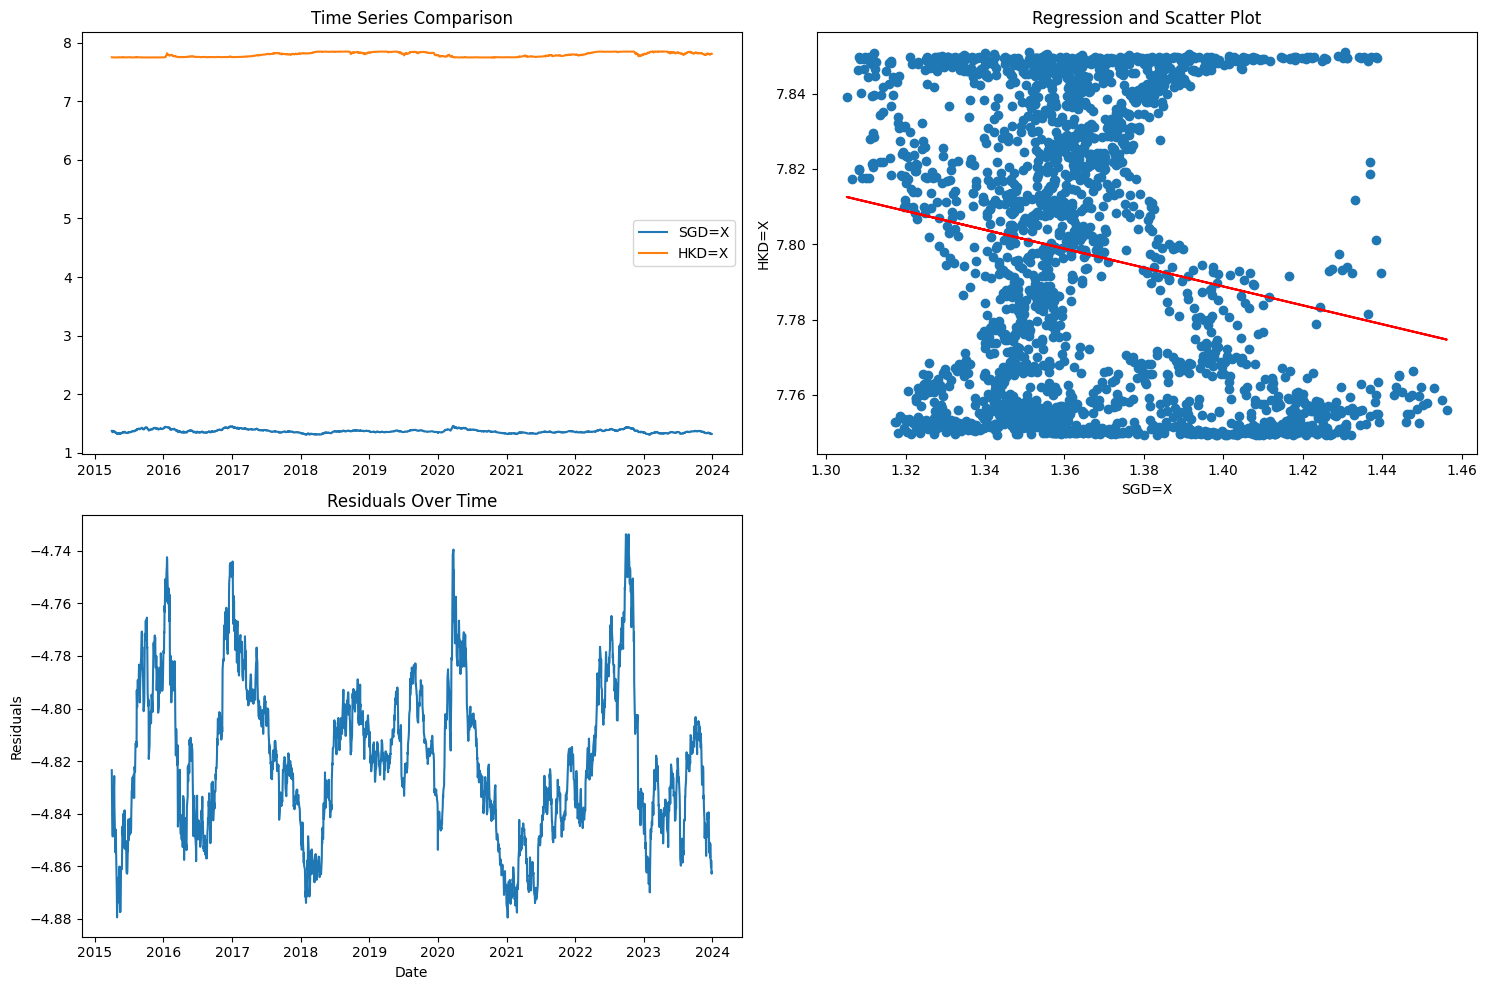

ADF Statistic: -3.475381
p-value: 0.008642
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [10]:
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
 
def download_data(stock, start, end):
    try:
        ticker = yf.download(stock, start, end)
        return pd.DataFrame({'price': ticker['Adj Close']})
    except Exception as e:
        print(f"Error downloading {stock}: {e}")
        return pd.DataFrame()
 
def perform_regression(data1, data2):
    slope, intercept, r_value, p_value, std_err = linregress(data1.values[:, 0], data2.values[:, 0])
    residuals = data1 - slope * data2 - intercept
    return residuals, slope, intercept, r_value, p_value, std_err
 
def test_stationarity(data):
    result = adfuller(data['price'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
 
def create_dashboard(data1, data2, residuals, slope, intercept, label1, label2):
    plt.figure(figsize=(15, 10))
 
    # Time Series Plot
    plt.subplot(2, 2, 1)
    plt.plot(data1, label=label1)
    plt.plot(data2, label=label2)
    plt.title('Time Series Comparison')
    plt.legend()
 
    # Scatter Plot with Regression Line
    plt.subplot(2, 2, 2)
    plt.scatter(data1.values, data2.values)
    plt.plot(data1, slope * data1 + intercept, color='red')  # regression line
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title('Regression and Scatter Plot')
 
    # Residuals Plot
    plt.subplot(2, 2, 3)
    plt.plot(residuals)
    plt.title('Residuals Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
 
    plt.tight_layout()
    plt.show()
 
if __name__ == '__main__':
    start_date = datetime.datetime(2015, 4, 1)
    end_date = datetime.datetime(2023, 12, 31)
 
    stock1 = 'SGD=X'
    stock2 = 'HKD=X'
 
    data1 = download_data(stock1, start_date, end_date)
    data2 = download_data(stock2, start_date, end_date)
 
    if not data1.empty and not data2.empty:
        residuals, slope, intercept, r_value, p_value, std_err = perform_regression(data1, data2)
        print(f"Regression R-squared: {r_value**2}, p-value: {p_value}, Standard Error: {std_err}")
 
        create_dashboard(data1['price'], data2['price'], residuals, slope, intercept, stock1, stock2)
        test_stationarity(residuals)